In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/Documents/AlgebraicJulia/CANMOD-2022/notebooks`


In [53]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.WiringDiagrams, Catlab.Programs, Catlab.Graphics
using AlgebraicPetri

draw(uwd::AbstractUWD) = to_graphviz(uwd, junction_labels=:variable, box_labels=:name);

# Composing Petri Nets

## A first example - SIR
Here we construct an SIR model as the composition of an infection process and a recovery process. 

### The interaction pattern

For composing Petri nets the interaction pattern is given by an undirected wiring diagram (UWD). As a $\mathcal{C}\mathsf{-Set}$ a UWD has the schema:

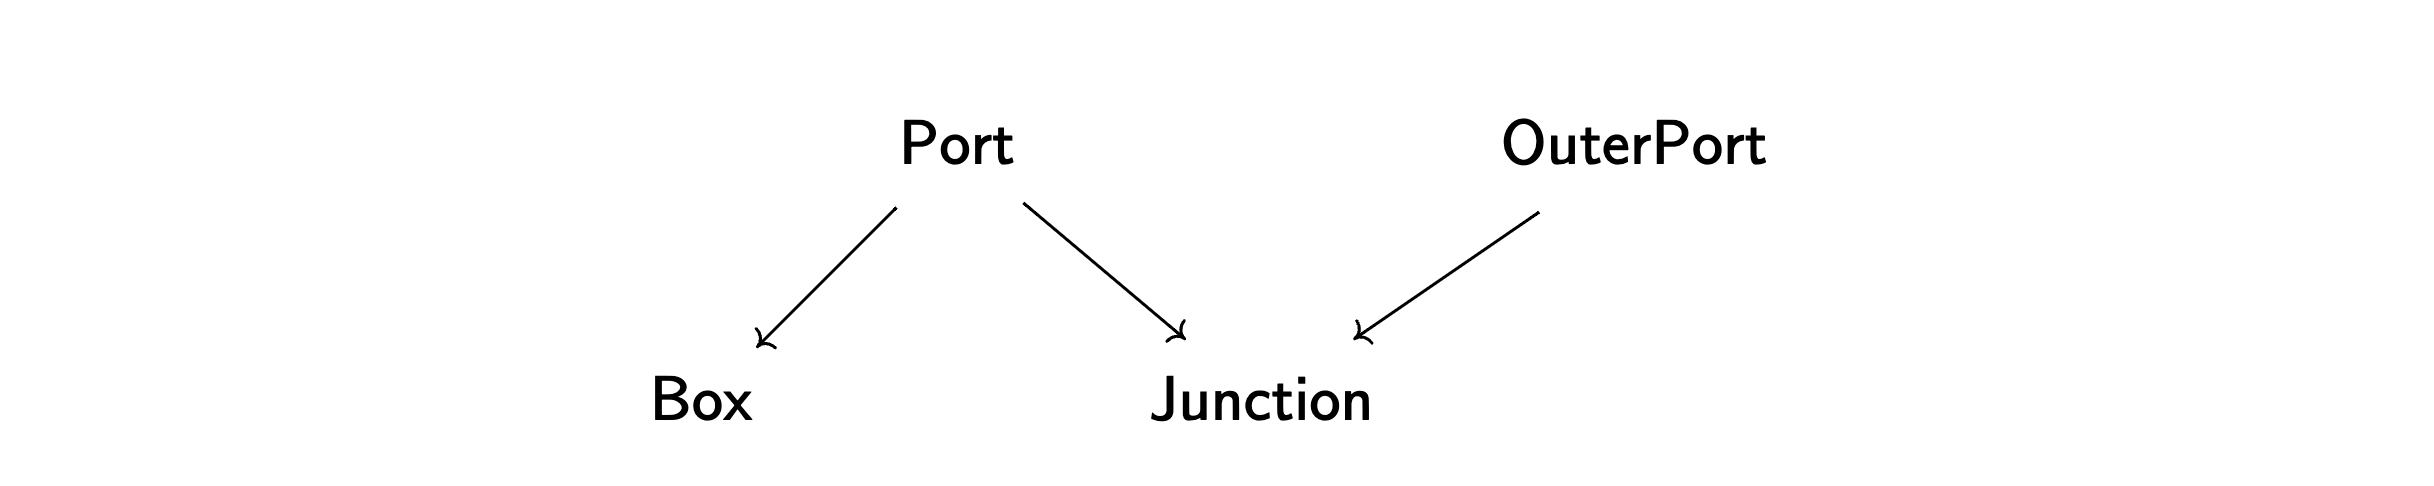

However, in Catlab we can use the `@relation` macro to define the UWD. 

In [56]:
interaction_pattern = @relation (S, I, R) begin 
    infection(S, I)
    recovery(I, R)
end

Catlab.Programs.RelationalPrograms.UntypedUnnamedRelationDiagram{Symbol, Symbol} with elements Box = 1:2, Port = 1:4, OuterPort = 1:3, Junction = 1:3
┌─────┬───────────┐
│ Box │      name │
├─────┼───────────┤
│   1 │ infection │
│   2 │  recovery │
└─────┴───────────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   2 │        2 │
│    4 │   2 │        3 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
│         3 │              3 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        S │
│        2 │        I │
│        3 │        R │
└──────────┴──────────┘

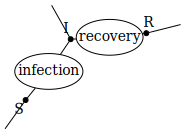

In [60]:
draw(interaction_pattern)

### The component models

Next we define two open Petri nets that "fill" the infection and recovery boxes.

interface type: 2

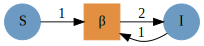

In [71]:
inf_net = LabelledPetriNet([:S, :I],
    :β => ((:S, :I) => (:I, :I))
)

open_inf = Open(inf_net, [:S], [:I])

print("interface type: ", length(legs(open_inf)))
Graph(open_inf)

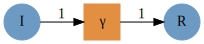

In [67]:
rec_net = LabelledPetriNet([:I, :R],
    :γ => (:I => :R)
)

open_rec = Open(rec_net, [:I], [:R])

Graph(open_rec)

### Compose!

Finally, we compose the component models `open_inf` and `open_rec` using the UWD `interaction_pattern`. Graphing the result we indeed get the SIR model. 

interface type: 3

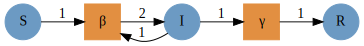

In [74]:
sir = oapply(interaction_pattern, Dict([
            :infection => open_inf, 
            :recovery => open_rec
]));

print("interface type: ", length(legs(sir)))
Graph(sir)

## Independence of syntax and semantics

One of the advantages of compositional modeling using operad algebras is that you can adjust the semantics (the choice of component models) and syntax (the choice of interaction pattern) independently. 

### Change the semantics

Consider replacing the component infection model with an SEI model that accounts for incubation. 

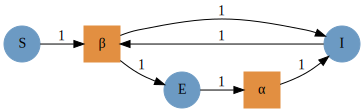

In [50]:
sei_net = LabelledPetriNet([:S, :E, :I],
    :β => ((:S, :I) => (:E, :I)),
    :α => (:E => :I)
)

open_sei = Open(sei_net, [:S], [:I])

Graph(sei_net)

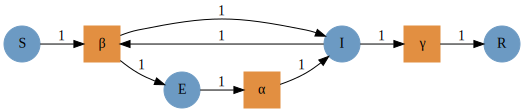

In [52]:
seir = oapply(interaction_pattern, Dict([
            :infection => open_sei, 
            :recovery => open_rec
]));

Graph(seir)

### Change the syntax

On the other hand consider changing the interaction pattern so that the recovered population is identified with the susceptible population. This adjustment leads to an SIS model of infection. 

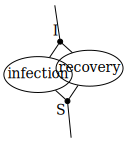

In [45]:
sis_interaction = @relation (S, I) begin 
    infection(S, I)
    recovery(I, S)
end

draw(sis_interaction)

In [80]:
open_rec_unlabelled = Open(PetriNet(rec_net), [1], [2]);
open_inf_unlabelled = Open(PetriNet(inf_net), [1], [2]);

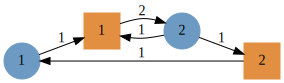

In [82]:
sis = oapply(sis_interaction, Dict([:infection => open_inf_unlabelled, :recovery => open_rec_unlabelled]));

Graph(sis)